## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units).  You have been provided a dataset, **accre-gpu-jobs-2022.csv**, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward. 

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.
2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?
3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?
4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [74]:
# Import packages needed for analysis and visualization
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
ACCRE = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_12943/1417506543.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ACCRE = pd.read_csv('accre-gpu-jobs-2022-v2.csv', error_bad_lines=False)
b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


In [76]:
ACCRE.head(20)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
5,32880721,glasshouse,brady,403.40M,3-12:00:00,18:49:36,1,1,1,pascal,0:0,COMPLETED
6,32880722,glasshouse,brady,0,3-12:00:00,3-12:00:07,1,1,1,pascal,0:0,COMPLETED
7,32880741,malanga,arline,1119.66M,2-00:00:00,08:09:18,1,2,1,pascal,0:0,COMPLETED
8,32880758,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,CANCELLED by 9201
9,32880759,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,CANCELLED by 9201


In [77]:
ACCRE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [78]:
ACCRE.shape

(336950, 12)

In [79]:
# Remove letter M from USEDMEM column of dataframe
ACCRE['USEDMEM']=ACCRE['USEDMEM'].str.replace('M', '')
ACCRE['USEDMEM']=ACCRE['USEDMEM'].astype(float)

In [80]:
ACCRE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   JOBID      336950 non-null  object 
 1   ACCOUNT    336950 non-null  object 
 2   USER       336950 non-null  object 
 3   USEDMEM    336950 non-null  float64
 4   REQTIME    336950 non-null  object 
 5   USEDTIME   336950 non-null  object 
 6   NODES      336950 non-null  int64  
 7   CPUS       336950 non-null  int64  
 8   GPUS       336950 non-null  int64  
 9   PARTITION  336950 non-null  object 
 10  EXITCODE   336950 non-null  object 
 11  STATE      336950 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 30.8+ MB


In [81]:
ACCRE['STATE'].unique()

array(['COMPLETED', 'CANCELLED by 9201', 'CANCELLED by 859023',
       'CANCELLED by 153500', 'CANCELLED by 168618',
       'CANCELLED by 888717', 'FAILED', 'CANCELLED by 859269',
       'CANCELLED by 756088', 'CANCELLED by 887337',
       'CANCELLED by 858683', 'CANCELLED', 'CANCELLED by 885613',
       'CANCELLED by 342288', 'CANCELLED by 855431',
       'CANCELLED by 491383', 'CANCELLED by 776393',
       'CANCELLED by 844796', 'CANCELLED by 780767',
       'CANCELLED by 505355', 'CANCELLED by 649321',
       'CANCELLED by 890189', 'CANCELLED by 59229', 'CANCELLED by 649319',
       'CANCELLED by 590520', 'CANCELLED by 478095',
       'CANCELLED by 196703', 'CANCELLED by 308082',
       'CANCELLED by 757496', 'CANCELLED by 454080',
       'CANCELLED by 512947', 'CANCELLED by 762866',
       'CANCELLED by 859465', 'CANCELLED by 161909',
       'CANCELLED by 785491', 'CANCELLED by 90423', 'CANCELLED by 159541',
       'CANCELLED by 859439', 'CANCELLED by 349259',
       'CANCELLED by 

In [82]:
ACCRE['EXITCODE'].unique()

array(['0:0', '127:0', '0:2', '1:0', '0:15', '0:9', '2:0', '0:6', '7:0',
       '126:0', '33:0', '13:0', '16:0', '0:125', '9:0', '0:7'],
      dtype=object)

In [83]:
ACCRE["REQTIME"].str.contains('-') 

0          True
1         False
2         False
3         False
4         False
          ...  
336945     True
336946     True
336947     True
336948     True
336949     True
Name: REQTIME, Length: 336950, dtype: bool

In [84]:

def time_to_hours(col): # Where col is a series gotten from the dataframe

    # Each row in USEDTIME/REQTIME is of the format:
    # Days-H:M:S
    # So we should be able to just take every value and convert them to seconds, then convert that final number to hours

    output_col = []
    for item in col:
        total_seconds = 0
        # item should be a string, ie 2-10:19:00
        # Split based on the :
        values = item.split(":")

        # Using the example 2-10:19:00
        total_seconds += float(values[2])       # 00
        total_seconds += float(values[1]) * 60  # 19

        # We can't just add values[0] because there's a chance it has a day attached to it
        # So values[0] may actually "2-10"
        if "-" in values[0]:
            day_split = values[0].split("-")
            total_seconds += float(day_split[1]) * 60 * 60      # 10
            total_seconds += float(day_split[0]) * 60 * 60 * 24 # 2
        else:
            total_seconds += float(values[0]) * 60 * 60         # 10

        # Convert seconds to hours
        total_hours = total_seconds / 60 / 60
        output_col.append(total_hours)
    return output_col


In [85]:
ACCRE['REQTIME_Hours']=time_to_hours(ACCRE['REQTIME'])
ACCRE

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,48.0
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED,5.0
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,5.0
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,20.0
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0.00,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING,120.0
336946,46754542,malanga,arline,0.00,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING,48.0
336947,46754560,malanga,arline,0.00,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING,48.0
336948,46754598,glasshouse,treva,145.24,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED,24.0


In [86]:
ACCRE['USEDTIME_Hours']=time_to_hours(ACCRE['USEDTIME'])
ACCRE

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,48.0,0.220278
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED,5.0,0.006111
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,5.0,0.149167
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,20.0,5.162778
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15.0,4.186111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0.00,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING,120.0,0.118611
336946,46754542,malanga,arline,0.00,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING,48.0,0.000000
336947,46754560,malanga,arline,0.00,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING,48.0,0.000000
336948,46754598,glasshouse,treva,145.24,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED,24.0,0.023889


In [87]:
ACCRE_Completed = ACCRE[ACCRE['STATE']== 'COMPLETED']
ACCRE_Completed


,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,48.0,0.220278
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED,5.0,0.006111
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,5.0,0.149167
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,20.0,5.162778
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15.0,4.186111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED,120.0,0.014444
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED,120.0,0.580833
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED,120.0,0.067500
336942,46754095,harovin,shannon,2820.52,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED,120.0,0.186944


In [88]:
ACCRE_Completed.groupby(['PARTITION', 'ACCOUNT','USER'])['USEDTIME_Hours'].sum().sort_values(ascending= False)

PARTITION  ACCOUNT     USER    
turing     harovin     porsha      72051.225000
pascal     glasshouse  collins     36128.736389
                       jolette     35495.081111
                       birdella    32735.093056
           antares     nakisha     25576.947500
                                       ...     
turing     glasshouse  gibson          0.001667
           bertanne    barbie          0.001389
pascal     glasshouse  margret         0.001111
           pecans      brigette        0.001111
maxwell    bertanne    ari             0.000000
Name: USEDTIME_Hours, Length: 265, dtype: float64

In [89]:
ACCRE_Completed.groupby(['ACCOUNT'])['USEDTIME_Hours'].sum().sort_values(ascending= False)

ACCOUNT
glasshouse       259663.222500
harovin           90274.837500
antares           26701.298611
virginia          16652.165556
grisette          15535.382778
clara              6463.001389
prince             6206.466389
pecans             4616.035556
orange             4594.072500
plumcot            4116.344722
sunburst           2858.116111
malanga            2508.606667
kinnow             1763.697222
almonds             647.675833
white               569.064444
horseradish         483.200000
pinole              370.590278
apple               310.253611
pasilla             246.231944
cactus              235.876667
bertanne            234.646667
packham             212.023056
sugranineteen        72.609722
summer               48.004722
rosemarie             4.254722
gem                   2.238889
bunch                 0.209444
Name: USEDTIME_Hours, dtype: float64

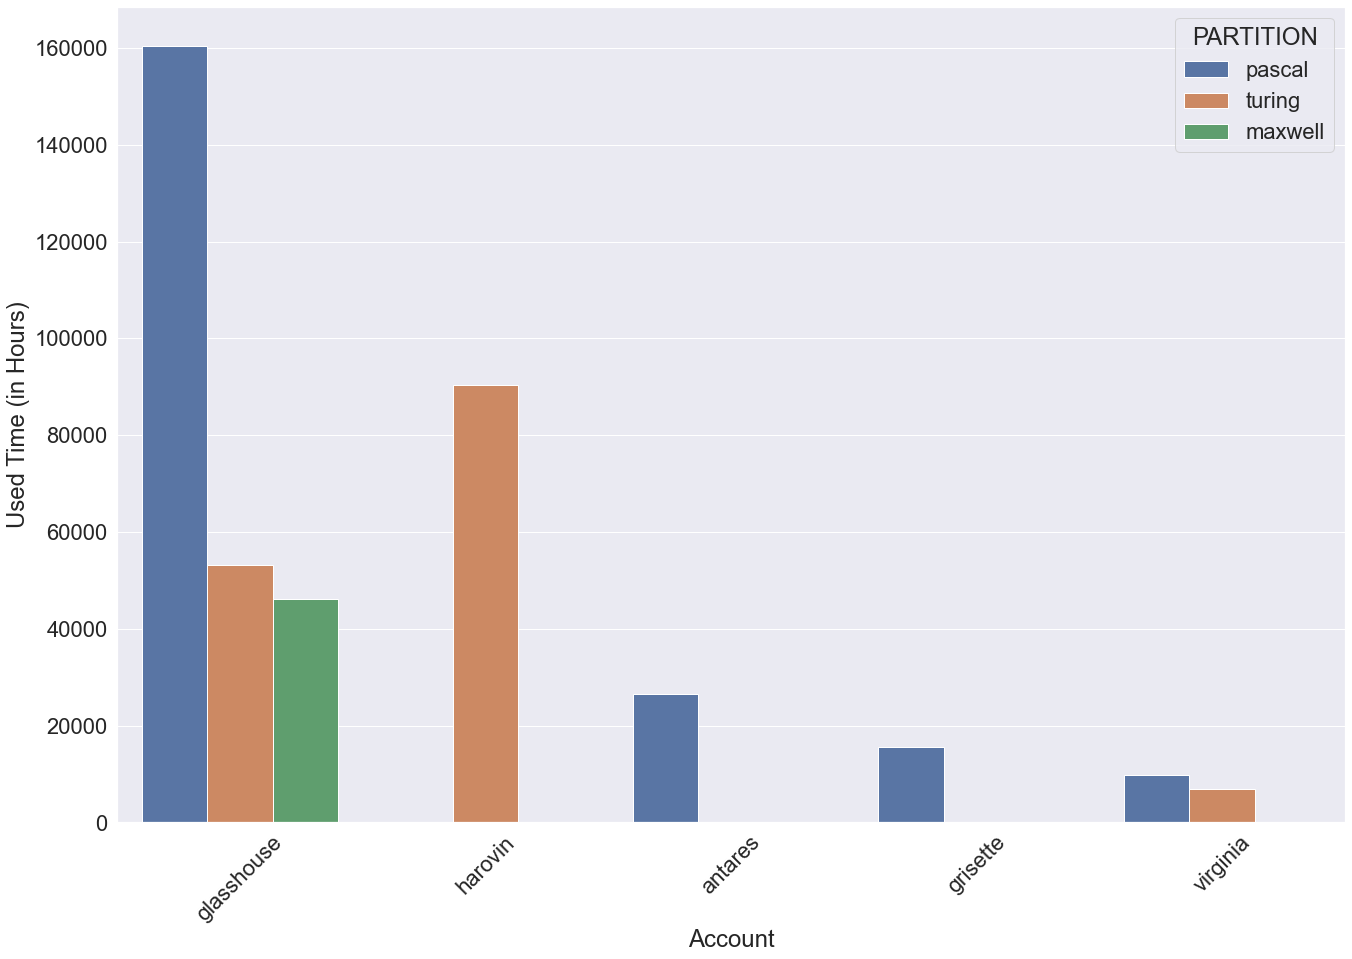

In [133]:
sns.set(font_scale=2)
plt.figure(figsize = (22,15))
sns.barplot(data = ACCRE_Completed.groupby(['ACCOUNT', 'PARTITION'])['USEDTIME_Hours'].sum().sort_values(ascending= False).head(8).to_frame().reset_index(), x ='ACCOUNT', 
            y='USEDTIME_Hours', hue = 'PARTITION')
plt.ylabel('Used Time (in Hours)')
plt.xlabel('Account')
plt.xticks(rotation =45);



In [91]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = ACCRE_Completed.groupby(['ACCOUNT'])['USEDTIME_Hours']).sum(), x ='ACCOUNT', y ='USEDTIME_Hours')
plt.xticks(rotation = 45);



SyntaxError: cannot assign to function call (1391731577.py, line 2)

In [92]:
from plotly.subplots import make_subplots

In [93]:
import plotly.express as px
import plotly.graph_objects as go
from raceplotly.plots import barplot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'malanga'),
  Text(1, 0, 'glasshouse'),
  Text(2, 0, 'sunburst'),
  Text(3, 0, 'virginia'),
  Text(4, 0, 'antares'),
  Text(5, 0, 'harovin'),
  Text(6, 0, 'prince'),
  Text(7, 0, 'orange'),
  Text(8, 0, 'grisette'),
  Text(9, 0, 'horseradish'),
  Text(10, 0, 'pecans'),
  Text(11, 0, 'pinole'),
  Text(12, 0, 'clara'),
  Text(13, 0, 'pasilla'),
  Text(14, 0, 'plumcot'),
  Text(15, 0, 'kinnow'),
  Text(16, 0, 'almonds'),
  Text(17, 0, 'apple'),
  Text(18, 0, 'bunch'),
  Text(19, 0, 'bertanne'),
  Text(20, 0, 'cactus'),
  Text(21, 0, 'packham'),
  Text(22, 0, 'summer'),
  Text(23, 0, 'white'),
  Text(24, 0, 'sugranineteen'),
  Text(25, 0, 'gem'),
  Text(26, 0, 'rosemarie')])

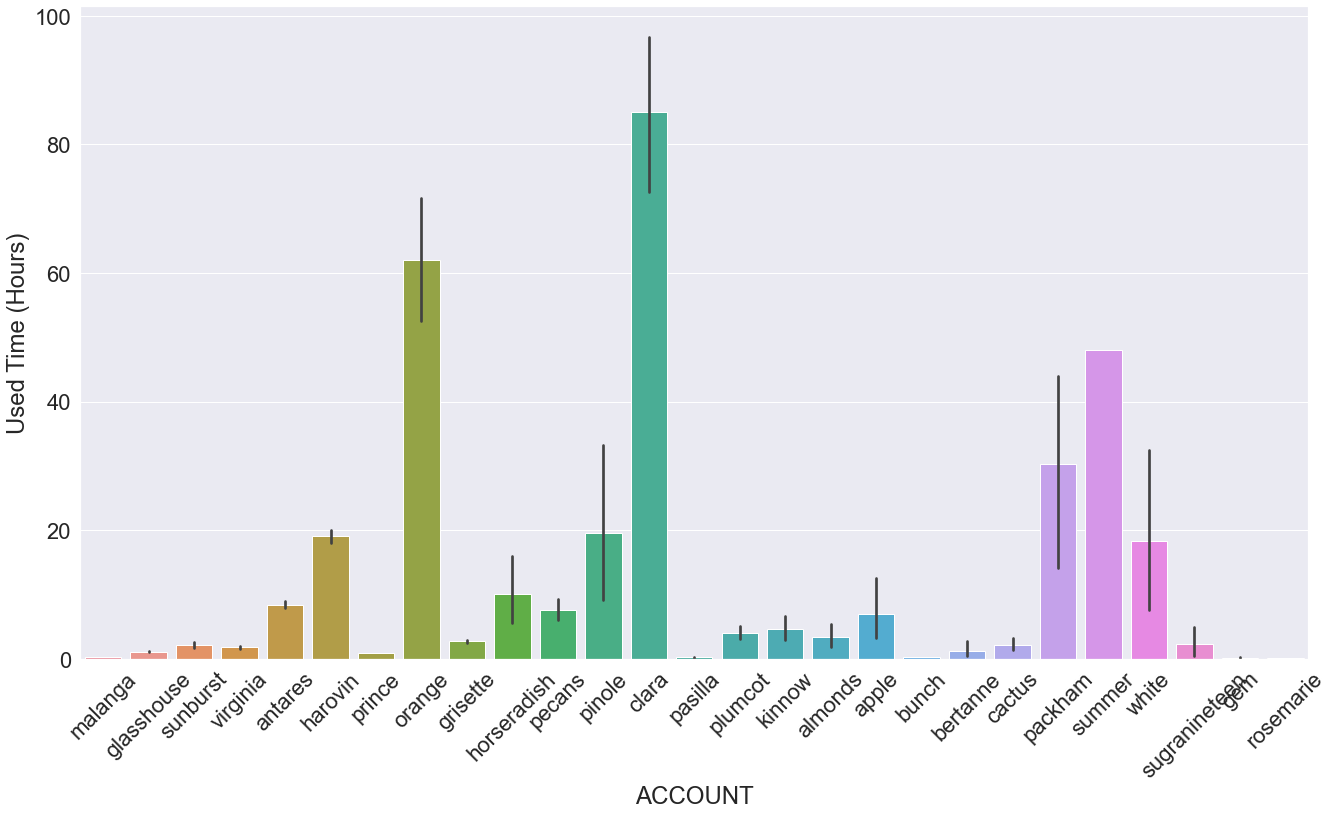

In [94]:
sns.set(font_scale=2)
plt.figure(figsize=(22, 12))
ax = sns.barplot(x='ACCOUNT', y='USEDTIME_Hours', data=ACCRE_Completed)
ax.set(ylabel='Used Time (Hours)')
plt.xticks(rotation = 45)


Ques 3: What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus)
in each of the 3 partitions over the last year?

In [95]:
gpu_completed_df_q3 = ACCRE_Completed
gpu_completed_df_q3["USAGE_PER_GPU"] = gpu_completed_df_q3["GPUS"] * gpu_completed_df_q3["USEDTIME_Hours"]
gpu_completed_df_q3.groupby(["PARTITION"])["USAGE_PER_GPU"].sum()

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_12943/3868826988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpu_completed_df_q3["USAGE_PER_GPU"] = gpu_completed_df_q3["GPUS"] * gpu_completed_df_q3["USEDTIME_Hours"]


PARTITION
maxwell     92701.636667
pascal     334872.838056
turing     204650.596667
Name: USAGE_PER_GPU, dtype: float64

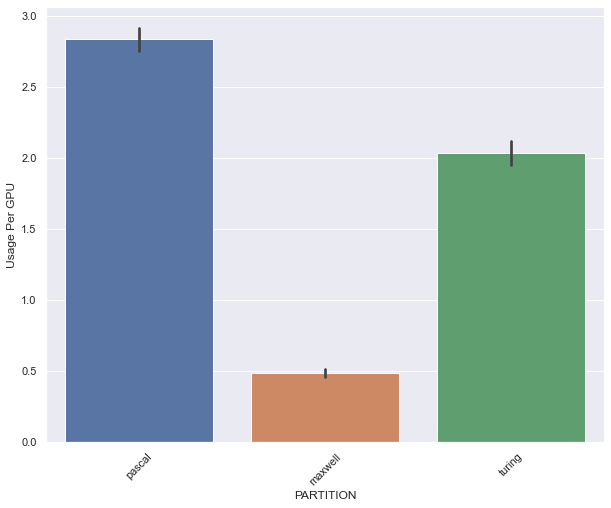

In [121]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='PARTITION', y='USEDTIME_Hours', data=gpu_completed_df_q3)
ax.set(ylabel='Usage Per GPU')
plt.xticks(rotation = 45);



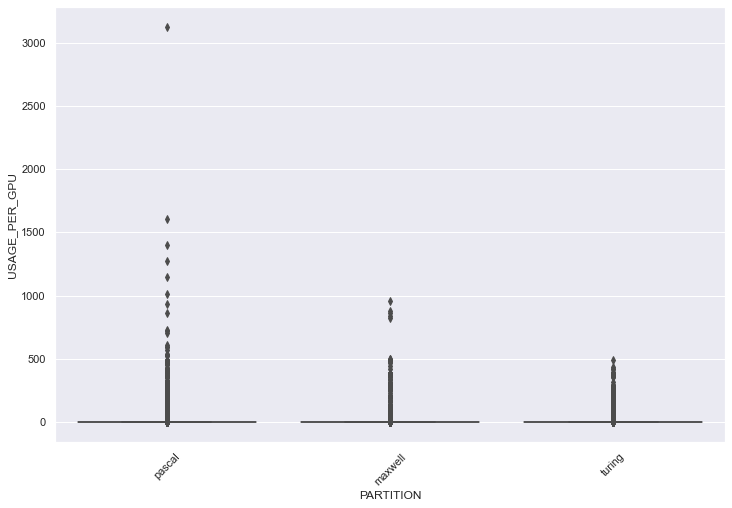

In [97]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data = gpu_completed_df_q3 , x ='PARTITION', y ='USAGE_PER_GPU')
plt.xticks(rotation = 45);

Ques 4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

In [98]:
gpu_completed_df_q4 = ACCRE_Completed
gpu_completed_df_q4.groupby(["PARTITION","ACCOUNT","USER"])["USEDTIME_Hours"].sum().sort_values(ascending = False)

PARTITION  ACCOUNT     USER    
turing     harovin     porsha      72051.225000
pascal     glasshouse  collins     36128.736389
                       jolette     35495.081111
                       birdella    32735.093056
           antares     nakisha     25576.947500
                                       ...     
turing     glasshouse  gibson          0.001667
           bertanne    barbie          0.001389
pascal     glasshouse  margret         0.001111
           pecans      brigette        0.001111
maxwell    bertanne    ari             0.000000
Name: USEDTIME_Hours, Length: 265, dtype: float64

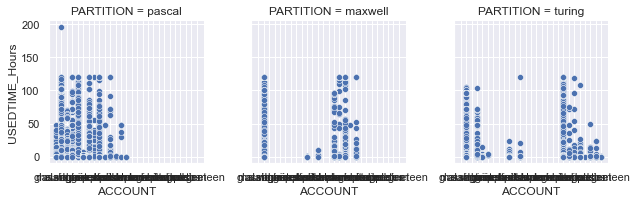

In [99]:

g = sns.FacetGrid(gpu_completed_df_q4 , col = 'PARTITION')
g.map(sns.scatterplot,'ACCOUNT','USEDTIME_Hours');

Ques 5 Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?

In [100]:
ACCRE_Completed['Dif_Hours']= ACCRE_Completed['REQTIME_Hours'] - ACCRE_Completed['USEDTIME_Hours']

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_12943/752968205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACCRE_Completed['Dif_Hours']= ACCRE_Completed['REQTIME_Hours'] - ACCRE_Completed['USEDTIME_Hours']


In [101]:
ACCRE_Completed

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,48.0,0.220278,0.220278,47.779722
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED,5.0,0.006111,0.006111,4.993889
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,5.0,0.149167,0.149167,4.850833
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,20.0,5.162778,5.162778,14.837222
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15.0,4.186111,4.186111,10.813889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED,120.0,0.014444,0.014444,119.985556
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED,120.0,0.580833,0.580833,119.419167
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED,120.0,0.067500,0.067500,119.932500
336942,46754095,harovin,shannon,2820.52,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED,120.0,0.186944,0.186944,119.813056


In [102]:
len(ACCRE_Completed[ACCRE_Completed["Dif_Hours"] <= 0])

2916

In [103]:
ACCRE_Completed[ACCRE_Completed["Dif_Hours"] <= 0]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours
6,32880722,glasshouse,brady,0.00,3-12:00:00,3-12:00:07,1,1,1,pascal,0:0,COMPLETED,84.0,84.001944,84.001944,-0.001944
80,32881540,virginia,garrett,4039.36,02:00:00,02:00:05,1,6,1,turing,0:0,COMPLETED,2.0,2.001389,2.001389,-0.001389
91,32882556,virginia,garrett,55.39,06:00:00,06:00:05,1,6,1,turing,0:0,COMPLETED,6.0,6.001389,6.001389,-0.001389
92,32882567,virginia,garrett,281.12,06:00:00,06:00:05,1,6,1,turing,0:0,COMPLETED,6.0,6.001389,6.001389,-0.001389
93,32882568,virginia,garrett,57.32,06:00:00,06:00:17,1,6,1,turing,0:0,COMPLETED,6.0,6.004722,6.004722,-0.004722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336505,46652721,glasshouse,miya,82.70,10:00:00,10:00:26,1,1,1,pascal,0:0,COMPLETED,10.0,10.007222,10.007222,-0.007222
336628,46655849,glasshouse,miya,72.32,10:00:00,10:00:01,1,1,1,pascal,0:0,COMPLETED,10.0,10.000278,10.000278,-0.000278
336630,46655855,virginia,diandra,407.18,02:00:00,02:00:06,1,6,1,turing,0:0,COMPLETED,2.0,2.001667,2.001667,-0.001667
336808,46745423,virginia,diandra,464.67,04:00:00,04:00:01,1,6,1,turing,0:0,COMPLETED,4.0,4.000278,4.000278,-0.000278


In [104]:
len(ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > 120])

750

In [105]:
ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > 120]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours
1825,32902926_2,harovin,shannon,0.00,5-00:00:00,5-00:00:15,1,1,1,turing,0:0,COMPLETED,120.0,120.004167,120.004167,-0.004167
1826,32902926_3,harovin,shannon,0.00,5-00:00:00,5-00:00:15,1,1,1,turing,0:0,COMPLETED,120.0,120.004167,120.004167,-0.004167
1827,32902926_4,harovin,shannon,0.00,5-00:00:00,5-00:00:15,1,1,1,turing,0:0,COMPLETED,120.0,120.004167,120.004167,-0.004167
10954,32959839,glasshouse,erick,231.29,5-00:00:00,5-00:00:16,1,1,1,maxwell,0:0,COMPLETED,120.0,120.004444,120.004444,-0.004444
10955,32959840,glasshouse,erick,230.78,5-00:00:00,5-00:00:16,1,1,1,maxwell,0:0,COMPLETED,120.0,120.004444,120.004444,-0.004444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334946,46534408,harovin,porsha,4024.16,5-00:00:00,5-00:00:14,1,6,1,turing,0:0,COMPLETED,120.0,120.003889,120.003889,-0.003889
334947,46534411,harovin,porsha,4886.82,5-00:00:00,5-00:00:14,1,6,1,turing,0:0,COMPLETED,120.0,120.003889,120.003889,-0.003889
335255,46558594,harovin,porsha,4097.02,5-00:00:00,5-00:00:25,1,6,1,turing,0:0,COMPLETED,120.0,120.006944,120.006944,-0.006944
335582,46573206_34,harovin,porsha,38337.19,5-00:00:00,5-00:00:22,1,6,1,turing,0:0,COMPLETED,120.0,120.006111,120.006111,-0.006111


In [106]:
ACCRE_Completed[ACCRE_Completed["USEDTIME_Hours"] > ACCRE_Completed["REQTIME_Hours"]]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours
6,32880722,glasshouse,brady,0.00,3-12:00:00,3-12:00:07,1,1,1,pascal,0:0,COMPLETED,84.0,84.001944,84.001944,-0.001944
80,32881540,virginia,garrett,4039.36,02:00:00,02:00:05,1,6,1,turing,0:0,COMPLETED,2.0,2.001389,2.001389,-0.001389
91,32882556,virginia,garrett,55.39,06:00:00,06:00:05,1,6,1,turing,0:0,COMPLETED,6.0,6.001389,6.001389,-0.001389
92,32882567,virginia,garrett,281.12,06:00:00,06:00:05,1,6,1,turing,0:0,COMPLETED,6.0,6.001389,6.001389,-0.001389
93,32882568,virginia,garrett,57.32,06:00:00,06:00:17,1,6,1,turing,0:0,COMPLETED,6.0,6.004722,6.004722,-0.004722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336505,46652721,glasshouse,miya,82.70,10:00:00,10:00:26,1,1,1,pascal,0:0,COMPLETED,10.0,10.007222,10.007222,-0.007222
336628,46655849,glasshouse,miya,72.32,10:00:00,10:00:01,1,1,1,pascal,0:0,COMPLETED,10.0,10.000278,10.000278,-0.000278
336630,46655855,virginia,diandra,407.18,02:00:00,02:00:06,1,6,1,turing,0:0,COMPLETED,2.0,2.001667,2.001667,-0.001667
336808,46745423,virginia,diandra,464.67,04:00:00,04:00:01,1,6,1,turing,0:0,COMPLETED,4.0,4.000278,4.000278,-0.000278


In [107]:
ACCRE_Completed[ACCRE_Completed["REQTIME_Hours"] == 120] 

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours
327,32884086,glasshouse,miya,374.89,5-00:00:00,1-08:38:34,1,1,1,pascal,0:0,COMPLETED,120.0,32.642778,32.642778,87.357222
1063,32891995,glasshouse,erick,242.00,5-00:00:00,4-19:44:31,1,1,1,pascal,0:0,COMPLETED,120.0,115.741944,115.741944,4.258056
1064,32891996,glasshouse,erick,244.33,5-00:00:00,4-19:44:31,1,1,1,pascal,0:0,COMPLETED,120.0,115.741944,115.741944,4.258056
1065,32891997,glasshouse,erick,243.17,5-00:00:00,4-19:44:31,1,1,1,pascal,0:0,COMPLETED,120.0,115.741944,115.741944,4.258056
1066,32891998,glasshouse,erick,243.82,5-00:00:00,4-19:44:31,1,1,1,pascal,0:0,COMPLETED,120.0,115.741944,115.741944,4.258056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336929,46753800,harovin,shannon,160.03,5-00:00:00,00:00:37,1,1,1,turing,0:0,COMPLETED,120.0,0.010278,0.010278,119.989722
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED,120.0,0.014444,0.014444,119.985556
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED,120.0,0.580833,0.580833,119.419167
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED,120.0,0.067500,0.067500,119.932500


In [111]:
ACCRE_Completed["Percentage_Diff"]=((ACCRE_Completed["Dif_Hours"]/ACCRE_Completed["REQTIME_Hours"])*100)
ACCRE_Completed

/var/folders/s3/9_r9v9px7_v0q69b5zcbnmsm0000gn/T/ipykernel_12943/3196675637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACCRE_Completed["Percentage_Diff"]=((ACCRE_Completed["Dif_Hours"]/ACCRE_Completed["REQTIME_Hours"])*100)


,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQTIME_Hours,USEDTIME_Hours,USAGE_PER_GPU,Dif_Hours,Percentage_Diff
0,32880657,malanga,arline,18.66,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED,48.0,0.220278,0.220278,47.779722,99.541088
1,32880701,glasshouse,brady,0.00,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED,5.0,0.006111,0.006111,4.993889,99.877778
2,32880718,glasshouse,brady,402.32,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED,5.0,0.149167,0.149167,4.850833,97.016667
3,32880719,glasshouse,brady,417.62,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED,20.0,5.162778,5.162778,14.837222,74.186111
4,32880720,glasshouse,brady,450.09,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED,15.0,4.186111,4.186111,10.813889,72.092593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED,120.0,0.014444,0.014444,119.985556,99.987963
336934,46753820_26,harovin,porsha,5093.70,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED,120.0,0.580833,0.580833,119.419167,99.515972
336936,46753823,harovin,shannon,156.21,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED,120.0,0.067500,0.067500,119.932500,99.943750
336942,46754095,harovin,shannon,2820.52,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED,120.0,0.186944,0.186944,119.813056,99.844213


In [114]:
(ACCRE_Completed["Percentage_Diff"]>50).value_counts()

True     273739
False      9594
Name: Percentage_Diff, dtype: int64

In [134]:
ACCRE_Completed["Percentage_Diff"].describe()

count    283333.000000
mean         94.518289
std          15.401735
min         -93.472222
25%          98.553241
50%          99.452778
75%          99.886111
max         100.000000
Name: Percentage_Diff, dtype: float64

In [135]:
ACCRE_Completed["Dif_Hours"].describe()

count    283333.000000
mean         22.527946
std          33.752488
min         -20.064722
25%           5.995000
50%           9.951667
75%          11.626667
max         273.769444
Name: Dif_Hours, dtype: float64